In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -----------------------------
# 1) 데이터 로드
# -----------------------------
df = pd.read_csv("/content/drive/MyDrive/violation_from_video.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

series = df["violation_level"].values.astype(np.float32)

# -----------------------------
# 2) window dataset 생성
# -----------------------------
WINDOW = 30   # 30분을 한 window
X = []
for i in range(len(series) - WINDOW):
    X.append(series[i:i+WINDOW])

X = np.array(X)
X_tensor = torch.tensor(X).unsqueeze(-1)   # (batch, window, 1)

dataset = TensorDataset(X_tensor, X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
class DenseAE(nn.Module):
    def __init__(self, window):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(window, 32),
            nn.ReLU(),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, window),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out.reshape(x.shape)

model = DenseAE(WINDOW).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ------------------------
# 학습
# ------------------------
for epoch in range(10):
    for batch, _ in loader:
        batch = batch.to(device)
        output = model(batch)
        loss = loss_fn(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0893
Epoch 2, Loss: 0.1145
Epoch 3, Loss: 0.1036
Epoch 4, Loss: 0.0954
Epoch 5, Loss: 0.0752
Epoch 6, Loss: 0.0669
Epoch 7, Loss: 0.0674
Epoch 8, Loss: 0.0648
Epoch 9, Loss: 0.0867
Epoch 10, Loss: 0.0886


In [12]:
class LSTMAE(nn.Module):
    def __init__(self, seq_len=30, n_features=1, embedding_dim=16, hidden_dim=64):
        super().__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim

        # ------------------------
        # ENCODER
        # ------------------------
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, embedding_dim)

        # ------------------------
        # DECODER
        # ------------------------
        self.fc_dec = nn.Linear(embedding_dim, hidden_dim)

        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        # seq 방향으로 feature(1)로 변환하는 projection layer
        self.out_layer = nn.Linear(hidden_dim, n_features)

    def forward(self, x):
        # ------------------------
        # ENCODE
        # ------------------------
        _, (h, _) = self.encoder(x)
        z = self.fc(h[-1])              # (batch, embedding_dim)

        # ------------------------
        # DECODE
        # ------------------------
        h_dec = self.fc_dec(z).unsqueeze(0)  # (1, batch, hidden_dim)
        c_dec = torch.zeros_like(h_dec)

        # decoder input: (batch, seq_len, hidden_dim)
        dec_input = torch.zeros(x.size(0), self.seq_len, self.hidden_dim).to(x.device)

        out, _ = self.decoder(dec_input, (h_dec, c_dec))   # (batch, seq, hidden_dim)
        out = self.out_layer(out)                          # (batch, seq, 1)

        return out


In [13]:
model = LSTMAE(seq_len=WINDOW, n_features=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    for batch, _ in loader:
        batch = batch.to(device)
        output = model(batch)
        loss = loss_fn(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f}")


[Epoch 1] Loss: 0.1844
[Epoch 2] Loss: 0.1340
[Epoch 3] Loss: 0.0871
[Epoch 4] Loss: 0.1064
[Epoch 5] Loss: 0.0789
[Epoch 6] Loss: 0.0898
[Epoch 7] Loss: 0.1089
[Epoch 8] Loss: 0.0784
[Epoch 9] Loss: 0.0878
[Epoch 10] Loss: 0.0900


In [14]:
# -----------------------------
# Reconstruction Error 계산
# -----------------------------
model.eval()
with torch.no_grad():
    reconstructed = model(X_tensor.to(device)).cpu().numpy()

errors = ((X - reconstructed.squeeze()) ** 2).mean(axis=1)


In [15]:
threshold = np.percentile(errors, 95)
labels = (errors > threshold).astype(int)

print("threshold:", threshold)
print("Detected anomalies:", labels.sum(), "/", len(labels))


threshold: 0.20223320424556723
Detected anomalies: 179 / 3570


In [16]:
time_index = df["timestamp"].values[WINDOW:]


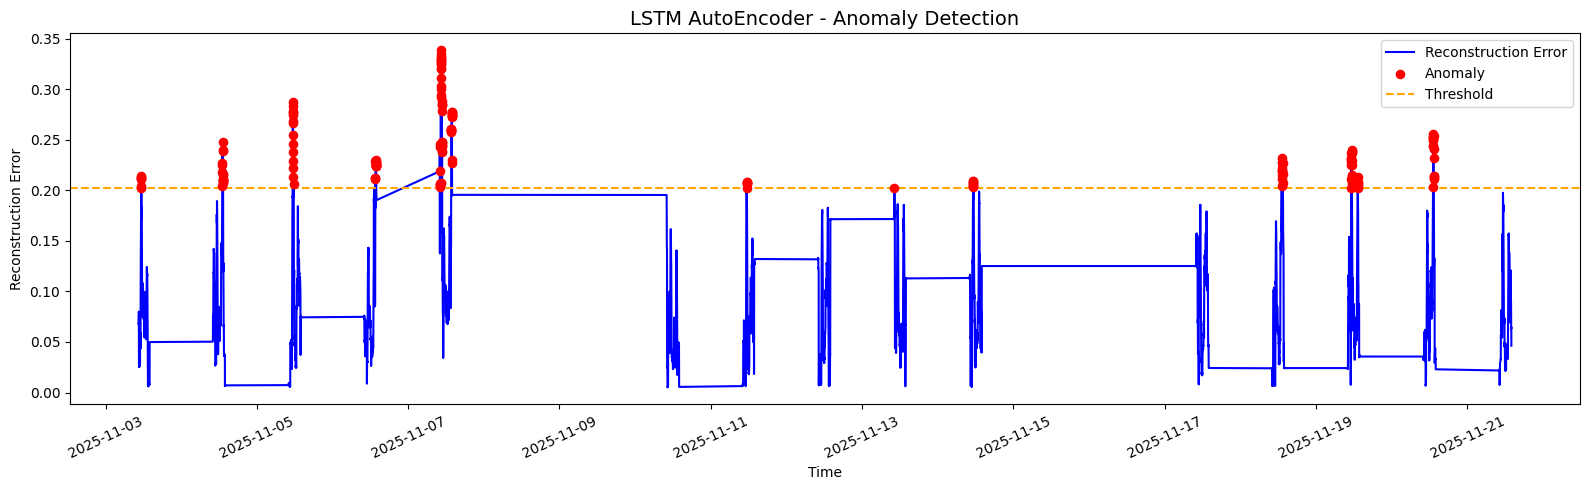

In [17]:
plt.figure(figsize=(16, 5))
plt.plot(time_index, errors, label="Reconstruction Error", color="blue")

plt.scatter(
    time_index[labels == 1],
    errors[labels == 1],
    color="red",
    s=35,
    label="Anomaly",
    zorder=5
)

plt.axhline(threshold, color="orange", linestyle="--", label="Threshold")
plt.title("LSTM AutoEncoder - Anomaly Detection", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


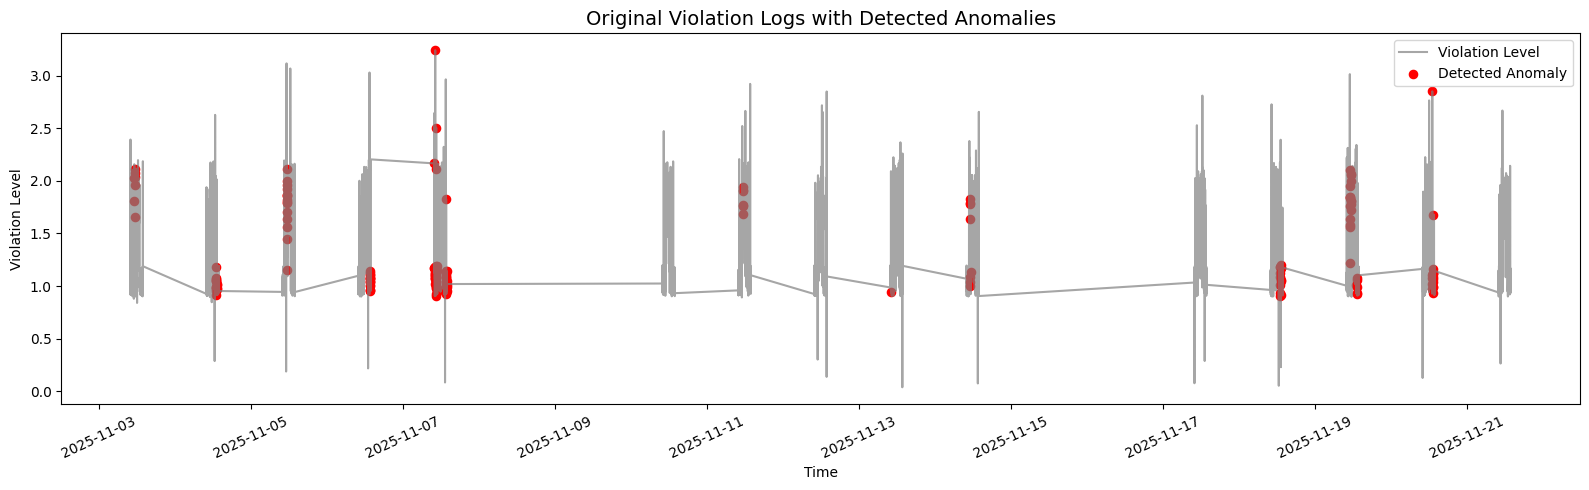

In [18]:
plt.figure(figsize=(16,5))
plt.plot(df["timestamp"].values, df["violation_level"], label="Violation Level", color="gray", alpha=0.7)

anom_times = time_index[labels == 1]
plt.scatter(
    anom_times,
    df.set_index("timestamp").loc[anom_times]["violation_level"],
    color="red",
    s=35,
    label="Detected Anomaly"
)

plt.title("Original Violation Logs with Detected Anomalies", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Violation Level")
plt.legend()
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


In [19]:
df_heat = df.copy()
df_heat["day"] = df_heat["timestamp"].dt.date
df_heat["hour"] = df_heat["timestamp"].dt.hour
df_heat["minute"] = df_heat["timestamp"].dt.minute


In [20]:
anom_series = np.concatenate([[0]*WINDOW, labels])
df_heat["anomaly"] = anom_series


In [21]:
pivot = df_heat.pivot_table(
    index="hour",
    columns="day",
    values="anomaly",
    aggfunc="sum"
)


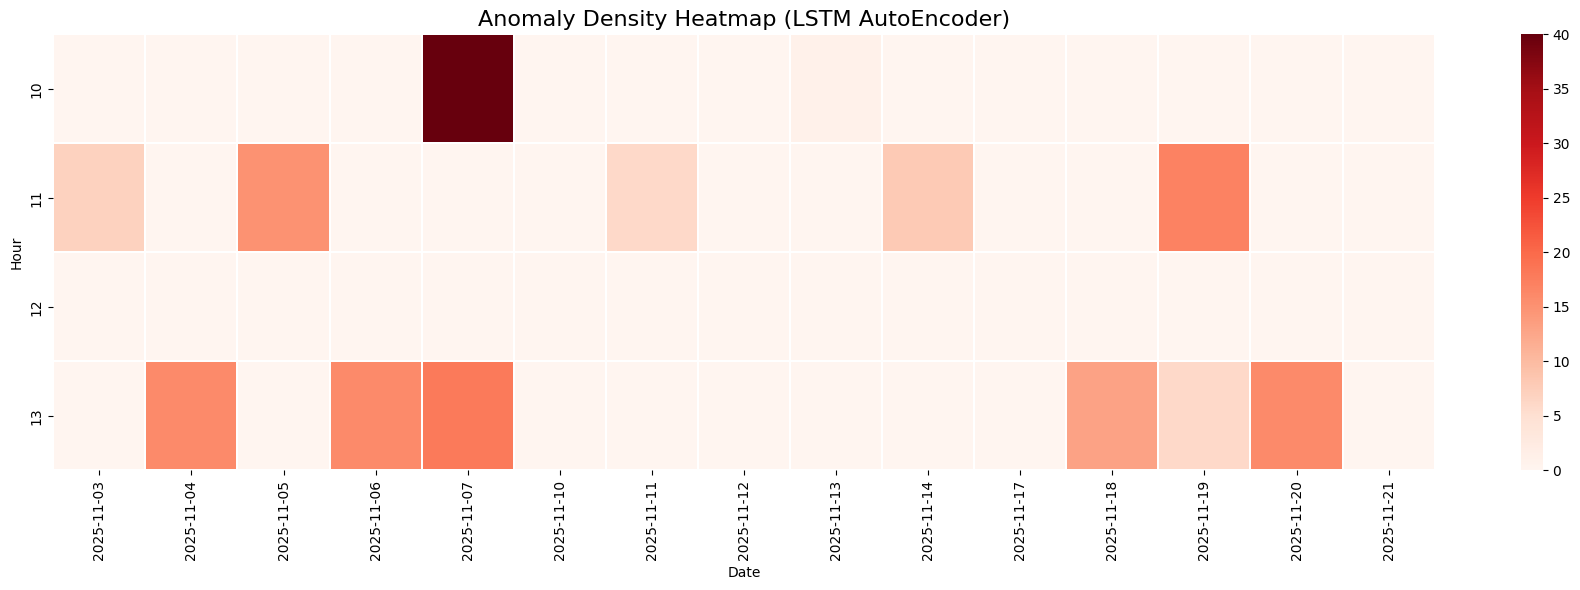

In [23]:
import seaborn as sns

plt.figure(figsize=(18,6))
sns.heatmap(pivot, cmap="Reds", linewidths=0.3, cbar=True)
plt.title("Anomaly Density Heatmap (LSTM AutoEncoder)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Hour")
plt.tight_layout()
plt.show()
